Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [ ]:
%capture
! pip install systole

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from systole.detection import ppg_peaks, interpolate_clipping, ecg_peaks
from systole.plots import plot_raw
from systole import import_dataset1, import_ppg
from systole import serialSim
from systole.recording import Oximeter

from bokeh.io import output_notebook
from bokeh.plotting import show
output_notebook()

sns.set_context('talk')

Loading BokehJS ...

# Detecting cardiac cycles

This notebook focus on the characterisation of cardiac cycles from the physiological signals we previously described (PPG and ECG). We only discuss here detection algorithms with a focus on the estimation of the heart rate frequency, as this is the most widely used reference in cognitive neuroscience. However, both the ECG and the PPG signals contain rich information that is relevant for cognitive modelling. All these approaches are not fully covered by [Systole](https://systole-docs.github.io/), but are implemented in other software (e.g see **[1]** for ECG components delineation).

In this notebook, we are going to approach the peaks detection algorithms that will be used in the next tutorials with more details. This is only intended to give a better intuition of what is happening during the detection, the corrections that can be applied, and the possible bias and artefacts that can emerge. However, you do not need a perfect understanding of all these steps if you want to use it, and you might also consider skipping this part a go directly to the next tutorial focusing on artefacts detection and correction.

## Electrocardiography

Because we will be interested in heart rate and its variability here, our first goal will be to detect the R peaks. We will use the `ecg_peaks()` function provided by Systole to perform R peak detection. This function is a simple wrapper for famous peaks detection algorithms that are implemented in the [py-ecg-detectors module](https://github.com/berndporr/py-ecg-detectors) **[2]**. The detection algorithm can be selected via the `ecg_method` parameter, it should be among the following: `hamilton`, `christov`, `engelse-zeelenberg`, `pan-tompkins`, `wavelet-transform`, `moving-average`. In this tutorial, we will use the [pan-tompkins algorithm](https://en.wikipedia.org/wiki/Pan%E2%80%93Tompkins_algorithm) **[3]** as it is a fast and commonly used algorithm for QRS detection.

Let's first load some ECG recording. Here, we will select 5 minumtes and compare the performances of the different algorutms supported by Systole.

In [21]:
# Import ECg recording
ecg_df = import_dataset1(modalities=['ECG'])
signal = ecg_df[ecg_df.time.between(60, 360)].ecg.to_numpy()  # Select 5 minutes

### Detecting R peaks
Remember the ECG cycles (image)
The main approach is to find R peaks to compute RR intervals.
Large variety of algorithms
Here, we will focus on the following methods: hamilton, christov, engelse-zeelenberg, pan-tompkins, wavelet-transform, moving-average.
Comes from the py-ecg-detectors module
Add numba support, which speed up the code (7-30x faster)

In [22]:
from systole.detectors import pan_tompkins, hamilton, moving_average, christov, engelse_zeelenberg

#### Pan-Tompkins

The [Pan-Tompkins algorithm](https://en.wikipedia.org/wiki/Pan%E2%80%93Tompkins_algorithm) was introduced in 1985. It uses band-pass filtering and derivation to identify the QRS complex and apply an adaptive threshold to detect the R peaks on the filtered signal.

This is a very popular - maybe to most popular - method for R peaks detection. One of the advantages is that it can easily be applied for online detection (see [this implementation](https://github.com/c-labpl/qrs_detector) for example). As we can see in the timing report, this algorithm is also very fast (it is the fastest we have in the Systole toolbox). You can also see that it is making a great job for peak detection as we do not see any artifacts in the R-R time series (except for the very first peak that is not accurately placed in the signal, this is due to the filtering steps in the Pan-Tompkins algorithms, and should be accommodated by using slightly longer signal than the range of interest).

In [24]:
%%timeit
peaks_pt = pan_tompkins(signal, sfreq=1000)

20 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
show(
    plot_raw(signal, modality='ecg', ecg_method='pan-tompkins', backend='bokeh', show_heart_rate=True)
)

#### Moving average

In [26]:
%%timeit
peaks_wa = ecg_peaks(signal, sfreq=1000, method="moving-average")

26.8 ms ± 870 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
show(
    plot_raw(signal, modality='ecg', ecg_method='moving-average', backend='bokeh', show_heart_rate=True)
)

#### Hamilton

In [28]:
%%timeit
peaks_ha = hamilton(signal, sfreq=1000)

32.6 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
show(
    plot_raw(signal, modality='ecg', ecg_method='hamilton', backend='bokeh', show_heart_rate=True)
)

#### Christov

In [30]:
%%timeit
peaks_ch = christov(signal, sfreq=1000)

393 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
show(
    plot_raw(signal, modality='ecg', ecg_method='christov', backend='bokeh', show_heart_rate=True)
)

#### Engelse-Zeelenberg

In [32]:
%%timeit
peaks_ew = engelse_zeelenberg(signal, sfreq=1000)

121 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
show(
    plot_raw(signal, modality='ecg', ecg_method='engelse-zeelenberg', backend='bokeh', show_heart_rate=True)
)

## Photoplethysmography

### Systolic peaks detection

#### Online

Let's first simulate some PPG recording. Here, we will use the `serialSim` calss from Systole in conjunction with the `Oximeter` recording class. This will *simulate* the presence of a pulse oximeter on the computer and provide the information from a pre-recorded signal in realistic time.

In [34]:
# Pulse oximeter simulation
ser = serialSim()

# Create an Oxymeter instance, initialize recording and record for 10 seconds
oxi = Oximeter(serial=ser, sfreq=75).setup()
oxi.read(20);

Reset input buffer


In [35]:
# Retrieve the data from the oxi class
times = np.array(oxi.times)
threshold = np.array(oxi.threshold)
recording = np.array(oxi.recording)
peaks = np.array(oxi.peaks)

This method uses the derivative to find peaks in the signal and select them based on and adaptive threshold based on the rolling mean and rolling standard deviation in a given time window.

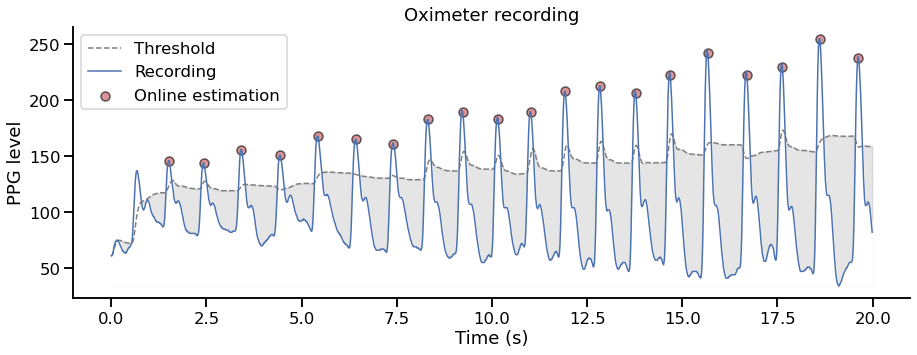

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Oximeter recording")

ax.plot(times, threshold, linestyle="--", color="gray", label="Threshold", linewidth=1.5)
ax.fill_between(
    x=times, y1=threshold, y2=recording.min(), alpha=0.2, color="gray"
)
ax.plot(times, recording, label="Recording", color="#4c72b0", linewidth=1.5)
ax.fill_between(x=times, y1=recording, y2=recording.min(), color="w")
ax.scatter(x=times[np.where(peaks)[0]], y=recording[np.where(peaks)[0]],
           color="#c44e52", alpha=.6, label="Online estimation",
           edgecolors='k')
ax.set_ylabel("PPG level")
ax.set_xlabel("Time (s)")
ax.legend()
sns.despine()

#### Offline

A simple online appraoch like the one we described is usually good enough to detect all the sysolic peaks, provided that the subject is not mooving too much. 

In [37]:
ppg = import_ppg()

**Clipping artefacts**

Clipping is a form of distortion that can limit signal when it exceeds a certain threshold [see the Wikipedia page](https://en.wikipedia.org/wiki/Clipping_(signal_processing)). Some device can produce clipping artefacts when recording the PPG signal. Here, we can see that some clipping artefacts are found between 100 and 150 seconds in the previous recording. The threshold values (here `255`), is often set by the device and can easily be found. These artefacts should be corrected before systolic peaks detection. One way to go is to remove the portion of the signal where clipping artefacts occurs and use cubic spline interpolation to reconstruct a plausible estimate of the *real* underlying signal. This is what the function `interpolate_clipping()` do **[4]**.

In [38]:
signal = ppg[ppg.time.between(110, 113)].ppg.to_numpy()  # Extract a portion of signal with clipping artefacts
clean_signal = interpolate_clipping(signal, threshold=255)  # Remove clipping segment and interpolate missing calues

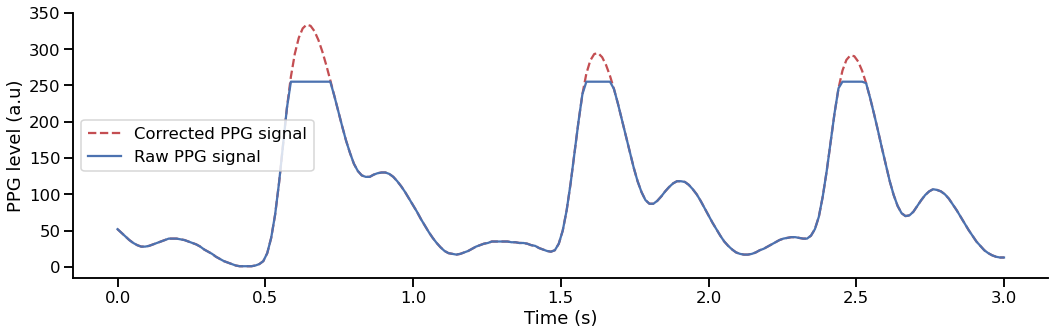

In [39]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(0, len(clean_signal))/75, clean_signal, label='Corrected PPG signal', linestyle= '--', color='#c44e52')
plt.plot(np.arange(0, len(signal))/75, signal, label='Raw PPG signal', color='#4c72b0')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('PPG level (a.u)')
sns.despine()
plt.tight_layout()

**References**

**[1]** Makowski, D., Pham, T., Lau, Z. J., Brammer, J. C., Lespinasse, F., Pham, H., Schölzel, C., & Chen, S. A. (2021). NeuroKit2: A Python toolbox for neurophysiological signal processing. Behavior Research Methods. https://doi.org/10.3758/s13428-020-01516-y **P, Q, S and T waves detection in the ECG signal. See also this tutorial:** https://neurokit2.readthedocs.io/en/latest/examples/ecg_delineate.html

**[2]** Porr, B., & Howell, L. (2019). R-peak detector stress test with a new noisy ECG database reveals significant performance differences amongst popular detectors. Cold Spring Harbor Laboratory. https://doi.org/10.1101/722397 **Python implementation of famous R peak detection algorithms tested against large dataset**.

**[3]** Pan, Jiapu; Tompkins, Willis J. (March 1985). "A Real-Time QRS Detection Algorithm". IEEE Transactions on Biomedical Engineering. BME-32 (3): 230–236. doi:10.1109/TBME.1985.325532 **This paper describes the first implementation of the Pan-Tompkins algorithm**

**[4]** van Gent, P., Farah, H., van Nes, N., & van Arem, B. (2019). HeartPy: A novel heart rate algorithm for the analysis of noisy signals. *Transportation Research Part F: Traffic Psychology and Behaviour, 66, 368–378*. https://doi.org/10.1016/j.trf.2019.09.015 **This paper describes of a simple systolic peak detection algorithm and clipping artefacts correction**.